In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split

from tqdm import tqdm

import textwrap

import shap

In [16]:
data = np.load('../processed_ntuples/chunking/chunk_wnu_data.npy')
print(data.shape)
data = np.concatenate((data[:,0:-2], data[:,-1].reshape(-1,1)), axis=1)
np.shape(data)

(527375, 39)


(527375, 38)

In [17]:
train, val = train_test_split(data, random_state=137) # setting the seed for reproducibility; the default train/test split is 0.75/0.25
print('lenght of training set', len(train), '\nlenght of validation set', len(val), '\nwidth of the sets: # of features + 1 flag (1-LL/0-TX)', len(train[0]))

lenght of training set 395531 
lenght of validation set 131844 
width of the sets: # of features + 1 flag (1-LL/0-TX) 38


In [18]:
# strip the last feature (e.g. the flag) from the sets

# first line check
print('first train line, before flag-stripping', train[0])

# copy in dedicated arrays
flags_train = train[:, -1]
flags_val = val[:, -1]
# delete from the sets
train = train[:, :-1]
val = val[:, :-1]
# width check
print('width of the samples, after flag-stripping', len(train[0]), len(val[0]))
# first line check
print('first train line, after flag-stripping', train[0])

first train line, before flag-stripping [ 0.45906499 -0.12419549  1.25075436  0.60235751 -0.59819829  0.27543196
 -0.69603062  0.1375009  -0.34067485  0.95107007  0.03541119  0.03541119
 -1.47387803 -0.62790096 -0.43924579 -0.53418443  0.82432126  1.29025299
 -0.26885132 -0.84468235 -1.12945417 -0.77744018 -1.80520892 -1.0771277
 -1.10550845  1.77859855 -0.55486745 -1.46640027  0.02515023  0.11602841
 -1.06045198  0.98780102  0.78678175  0.24963775  0.24672216  0.56147322
  0.78072666  0.        ]
width of the samples, after flag-stripping 37 37
first train line, after flag-stripping [ 0.45906499 -0.12419549  1.25075436  0.60235751 -0.59819829  0.27543196
 -0.69603062  0.1375009  -0.34067485  0.95107007  0.03541119  0.03541119
 -1.47387803 -0.62790096 -0.43924579 -0.53418443  0.82432126  1.29025299
 -0.26885132 -0.84468235 -1.12945417 -0.77744018 -1.80520892 -1.0771277
 -1.10550845  1.77859855 -0.55486745 -1.46640027  0.02515023  0.11602841
 -1.06045198  0.98780102  0.78678175  0.24963

In [19]:
# tensorize the data, so that pytorch doesn't whine
train = torch.tensor(train, dtype=torch.float32)
val = torch.tensor(val, dtype=torch.float32)
flags_train = torch.tensor(flags_train, dtype=torch.float32)
flags_val = torch.tensor(flags_val, dtype=torch.float32)

In [20]:
# creation of the model class
# (don't know if the sigmoid is defined in the best way possibile; this one just works)
class myModel(nn.Module):
    def __init__(self):
        super(myModel, self).__init__()
        self.dense1 = nn.Linear(37, 64)
        self.BatchNorm1d1 = nn.BatchNorm1d(64)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)
        self.dense2 = nn.Linear(64, 48)
        self.BatchNorm1d2 = nn.BatchNorm1d(48)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)
        self.dense3 = nn.Linear(48, 32)
        self.BatchNorm1d3 = nn.BatchNorm1d(32)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.1)
        self.dense4 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.dense1(x)
        x = self.BatchNorm1d1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.dense2(x)
        x = self.BatchNorm1d2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.dense3(x)
        x = self.BatchNorm1d3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = self.dense4(x)
        x = self.sigmoid(x)
        return x

In [21]:
model = torch.load('../models/results/norptwnu-model.pt', weights_only=False)
#model.eval()

In [22]:
predict = lambda x: model(torch.autograd.Variable(torch.from_numpy(x))).detach().numpy()

In [23]:
data_size = 1000
data = val[0:data_size].detach().numpy()

features_names = ['lepPt1', 'lepPt2', 'lepEta1', 'lepEta2', 'lepPhi1', 'lepPhi2',
            'vbsjetPt1', 'vbsjetPt2', 'vbsjetEta1', 'vbsjetEta2', 'vbsjetPhi1',
            'vbsjetPhi2', 'vbsjetM1', 'vbsjetM2', 'nvbsjetPt1', 'nvbsjetPt2',
            'nvbsjetEta1', 'nvbsjetEta2', 'nvbsjetPhi1', 'nvbsjetPhi2', 'nvbsjetM1',
            'nvbsjetM2', 'mjj', 'detajj', 'ptMET', 'phiMET', 'ptv1', 'ptv2',
            'etav1', 'etav2', 'phiv1', 'phiv2', 'costheta1', 'costheta2', 'CScostheta',
            'cos_th_1', 'cos_th_2']

In [24]:
torch.set_grad_enabled(False)
explainer = shap.KernelExplainer(predict, data)

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [25]:
#shap_values = explainer.shap_values(data)
#np.save('shapley_values/shap-values_norptwnu.npy', shap_values)
shap_values = np.load('shapley_values/shap-values_norptwnu.npy')

In [26]:
mean_abs_shap = np.abs(shap_values).mean(axis=0).flatten()

# Create a DataFrame for sorting
feature_importance = pd.DataFrame({
    'feature': features_names,
    'importance': mean_abs_shap
})

# Sort features by importance
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

print(feature_importance)

        feature  importance
22          mjj    0.123284
6     vbsjetPt1    0.117770
23       detajj    0.117397
7     vbsjetPt2    0.103784
26         ptv1    0.023448
10   vbsjetPhi1    0.017763
0        lepPt1    0.016238
11   vbsjetPhi2    0.016031
24        ptMET    0.011667
9    vbsjetEta2    0.009783
28        etav1    0.009330
29        etav2    0.005754
27         ptv2    0.005317
8    vbsjetEta1    0.005308
32    costheta1    0.004550
33    costheta2    0.004198
2       lepEta1    0.004001
34   CScostheta    0.003256
35     cos_th_1    0.003200
3       lepEta2    0.002482
4       lepPhi1    0.001817
1        lepPt2    0.001314
14   nvbsjetPt1    0.000884
25       phiMET    0.000629
20    nvbsjetM1    0.000617
31        phiv2    0.000606
12     vbsjetM1    0.000452
30        phiv1    0.000416
15   nvbsjetPt2    0.000404
36     cos_th_2    0.000390
5       lepPhi2    0.000387
18  nvbsjetPhi1    0.000337
13     vbsjetM2    0.000258
16  nvbsjetEta1    0.000249
17  nvbsjetEta2    0

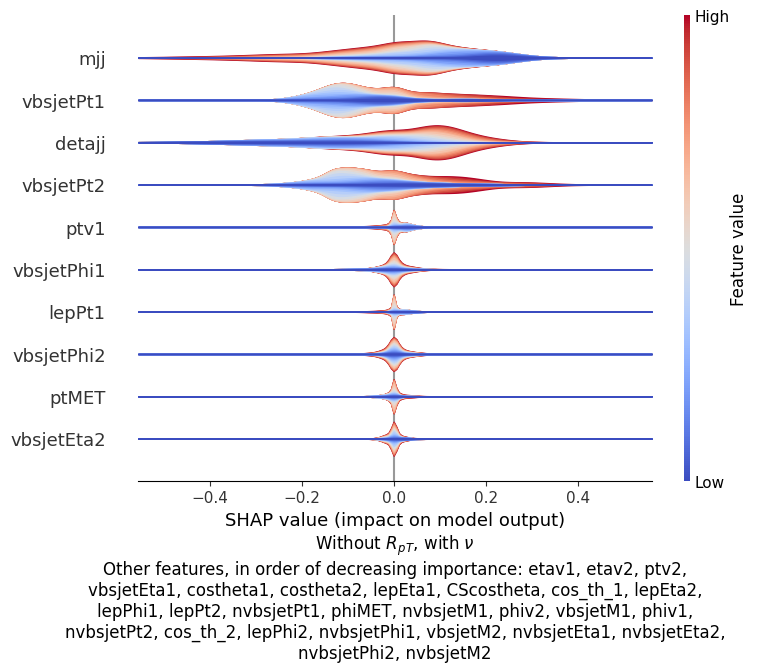

In [27]:
shap.summary_plot(shap_values[:,:,0], data, features_names, plot_type="layered_violin", max_display=10, show=False)
fig = plt.gcf()
fig.suptitle(f"Without $R_p$$_T$, with $\\nu$ \n"+'\n'.join(textwrap.wrap(f"Other features, in order of decreasing importance:\n{', '.join(feature_importance['feature'].to_numpy()[10:])}", width=int(fig.get_size_inches()[0] * 10))), y=0.02)
plt.savefig('figs/shap_norptwnu.png', dpi=500, bbox_inches='tight')

In [28]:
#